## Exercise 4
This exercise aims to apply process mining techniques to event logs, focusing on the construction of Petri Nets and alignment of process models with observed traces. The goal is to understand the process behaviors by analyzing different labels, constructing process models, and assessing the conformance of test traces to these models.

# Step 1
Partition the traces 

In [1]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import the event log from the file 'SepsisCases.xes':

log = xes_importer.apply('/Users/majidtavakoli/Documents/Medical_bionformatics/decision support systems/Ecxersices/SepsisCases.xes')
len(log)

/Users/majidtavakoli/Documents/Medical_bionformatics/decision support systems/Ecxersices/DSS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 3607.49it/s]


1050

In [3]:
# Visualize a trace, each trace is composed by the events of a patient: 

log[9]

{'attributes': {'concept:name': 'J'}, 'events': [{'InfectionSuspected': True, 'org:group': 'A', 'DiagnosticBlood': True, 'DisfuncOrg': False, 'SIRSCritTachypnea': True, 'Hypotensie': False, 'SIRSCritHeartRate': True, 'Infusion': True, 'DiagnosticArtAstrup': False, 'concept:name': 'ER Registration', 'Age': 80, 'DiagnosticIC': True, 'DiagnosticSputum': False, 'DiagnosticLiquor': False, 'DiagnosticOther': False, 'SIRSCriteria2OrMore': True, 'DiagnosticXthorax': True, 'SIRSCritTemperature': True, 'time:timestamp': datetime.datetime(2014, 1, 2, 16, 45, 45, tzinfo=datetime.timezone.utc), 'DiagnosticUrinaryCulture': False, 'SIRSCritLeucos': False, 'Oligurie': False, 'DiagnosticLacticAcid': True, 'lifecycle:transition': 'complete', 'Diagnose': 'B', 'Hypoxie': False, 'DiagnosticUrinarySediment': True, 'DiagnosticECG': True}, '..', {'org:group': 'E', 'lifecycle:transition': 'complete', 'concept:name': 'Release A', 'time:timestamp': datetime.datetime(2014, 1, 6, 11, 0, tzinfo=datetime.timezone.ut

In [4]:
# Extract unique labels for traces ending with specific events:
labels = list({trace[-1]['concept:name'] for trace in log if 'Re' in trace[-1]['concept:name']})
print(labels)

['Release B', 'Return ER', 'Release D', 'Release A', 'Release C', 'Release E']


In [5]:
# Partition traces by labels: 
trace_dict = {r: [trace for trace in log if trace[-1]['concept:name'] == r] for r in labels}
trace_dict

{'Release B': [{'attributes': {'concept:name': 'H'}, 'events': [{'InfectionSuspected': False, 'org:group': 'A', 'DiagnosticBlood': False, 'DisfuncOrg': False, 'SIRSCritTachypnea': True, 'Hypotensie': False, 'SIRSCritHeartRate': True, 'Infusion': False, 'DiagnosticArtAstrup': False, 'concept:name': 'ER Registration', 'Age': 80, 'DiagnosticIC': False, 'DiagnosticSputum': False, 'DiagnosticLiquor': False, 'DiagnosticOther': False, 'SIRSCriteria2OrMore': False, 'DiagnosticXthorax': False, 'SIRSCritTemperature': False, 'time:timestamp': datetime.datetime(2014, 3, 11, 9, 50, 2, tzinfo=datetime.timezone.utc), 'DiagnosticUrinaryCulture': False, 'SIRSCritLeucos': False, 'Oligurie': False, 'DiagnosticLacticAcid': False, 'lifecycle:transition': 'complete', 'Diagnose': 'G', 'Hypoxie': False, 'DiagnosticUrinarySediment': False, 'DiagnosticECG': False}, '..', {'org:group': 'E', 'lifecycle:transition': 'complete', 'concept:name': 'Release B', 'time:timestamp': datetime.datetime(2014, 3, 16, 1, 0, tzi

In [7]:
# Divide each trace in half and assign to trace_dict_test and trace_dict_train:

trace_dict_train = {}
trace_dict_test = {}

for key in trace_dict:
    trace = trace_dict[key]
    half_length = len(trace) // 2 
    trace_dict_test[key] = trace[:half_length]
    trace_dict_train[key] = trace[half_length:]

for key in trace_dict:
    print(f'{key}: test length = {len(trace_dict_test[key])}, train length = {len(trace_dict_train[key])}')

Release B: test length = 27, train length = 28
Return ER: test length = 145, train length = 146
Release D: test length = 7, train length = 7
Release A: test length = 196, train length = 197
Release C: test length = 9, train length = 10
Release E: test length = 2, train length = 3


# Step 2
Construct the Petri Net for each labl Event Log

In [8]:
# Function to create an event log for a desired label:
# (if a "Return ER" event is found in the trace, any "Release" events that occur before it are skipped)

def create_event_log(traces_list, key):
    
    log = EventLog()
    
    ER_traces = False
    if key == "Return ER" :
            ER_traces = True
    
    for trace_data in traces_list:
        trace = Trace()
            
        for event_data in trace_data:
           
            event_name = event_data.get('concept:name', 'Unknown')
            if ER_traces and event_name.startswith("Release"):
                continue
            
            event = Event(event_data)
            trace.append(event)
        
        log.append(trace)
    
    return log

In [9]:
# Create training logs and discover Petri nets for each label:

train_logs = {}

for key in trace_dict_train:
    
    train = create_event_log(trace_dict_train[key], key)
    
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(train)
    
    train_logs[key] = {
        'train': train,
        'net': net,
        'initial_marking': initial_marking,
        'final_marking': final_marking
    }

In [10]:
# Dictionary to hold training logs and Petri nets for each label
train_logs = {}

for key in trace_dict_train:
    # Create event log for the current key
    train_log = create_event_log(trace_dict_train[key], key)
    
    # Discover Petri net from the event log
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(train_log)
    
    # Store the results in the train_logs dictionary
    train_logs[key] = {
        'train': train_log,
        'net': net,
        'initial_marking': initial_marking,
        'final_marking': final_marking
    }

# Optional: Print information about the discovered Petri nets (for debugging purposes)
for key, log_data in train_logs.items():
    print(f"Label: {key}")
    print(f"Net: {log_data['net']}")
    print(f"Initial Marking: {log_data['initial_marking']}")
    print(f"Final Marking: {log_data['final_marking']}")
    print()


Label: Release B
Net: places: [ p_10, p_11, p_12, p_13, p_16, p_17, p_19, p_20, p_21, p_22, p_24, p_25, p_26, p_28, p_29, p_30, p_31, p_32, p_33, p_34, p_35, p_36, p_38, p_39, p_40, p_41, p_7, p_8, sink, source ]
transitions: [ (172829f6-1620-411a-8634-d65f5634bc98, 'ER Triage'), (1fd1e2e7-b872-4a2b-a85d-1ff821b09ee1, 'Admission IC'), (2da3b631-166e-4a4d-aeff-b695279281f7, 'ER Sepsis Triage'), (62ee6921-609a-4559-bff7-e0d83facee54, 'Leucocytes'), (6dc6ee02-b6e7-47a5-b65e-c97ddab73ce8, 'IV Liquid'), (af8af520-ea1b-4646-8ba8-04763de075db, 'Release B'), (b552efcd-482c-40cd-bfb6-48c3471ed043, 'CRP'), (dd70007c-439e-43b9-80d1-29a2d1452448, 'LacticAcid'), (ea162004-2ca9-49ee-8c98-8ef599b7c57a, 'ER Registration'), (ed8bc39a-32c4-4a44-9676-5427fae34b24, 'Admission NC'), (ff954335-9167-46e2-8f04-53193c95eb2a, 'IV Antibiotics'), (init_loop_13, None), (init_loop_23, None), (init_loop_28, None), (skip_10, None), (skip_12, None), (skip_15, None), (skip_16, None), (skip_17, None), (skip_22, None), (

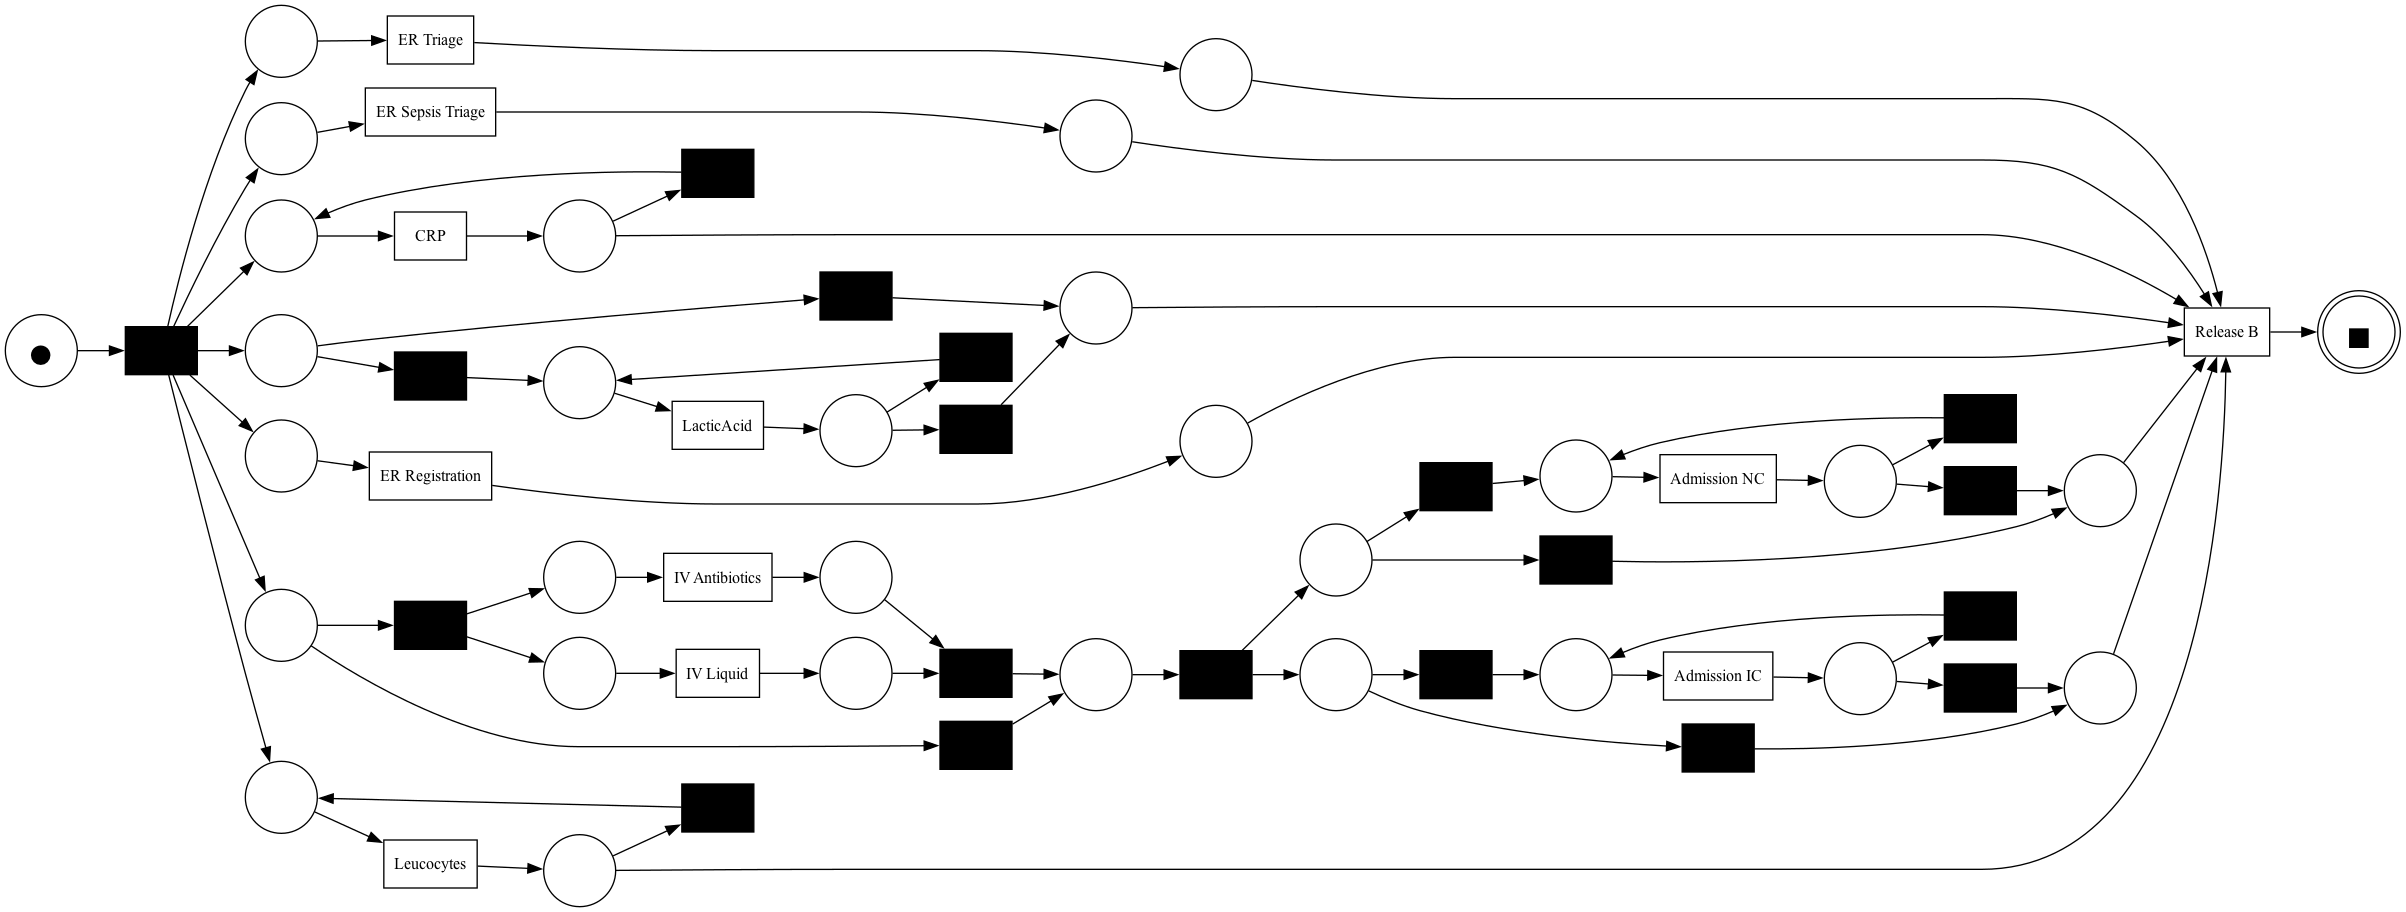

In [11]:
# View a Petri Net:
 
pm4py.view_petri_net(train_logs['Release B']['net'], train_logs['Release B']['initial_marking'], train_logs['Release B']['final_marking'])

# Step 3b and 4b
Aligning test sequences

In [12]:
# Create test logs:

test_logs = {}

for key in trace_dict_test:
    test_logs[key] = create_event_log(trace_dict_test[key], key)


In [13]:
# Align the test sequences with each of the created processes and save in a dictionary:

aligned_traces_dict = {}

for key in list(train_logs.keys()):
    print(key)
    net = train_logs[key]['net']
    initial_marking = train_logs[key]['initial_marking']
    final_marking = train_logs[key]['final_marking']
    
    aligned_traces = alignments.apply_log(test_logs[key], net, initial_marking, final_marking)
    aligned_traces_dict[key] = aligned_traces
    
for key, value in aligned_traces_dict.items():
    print(f"Aligned traces per {key}: {value}")


Release B


aligning log, completed variants :: 100%|██████████| 27/27 [00:00<00:00, 66.47it/s]


Return ER


aligning log, completed variants :: 100%|██████████| 143/143 [00:04<00:00, 31.14it/s]


Release D


aligning log, completed variants :: 100%|██████████| 7/7 [00:00<00:00,  9.25it/s]


Release A


aligning log, completed variants :: 100%|██████████| 181/181 [00:10<00:00, 16.52it/s]


Release C


aligning log, completed variants :: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s]


Release E


aligning log, completed variants :: 100%|██████████| 2/2 [00:00<00:00, 60.33it/s]

Aligned traces per Release B: [{'alignment': [('>>', None), ('>>', None), ('>>', None), ('>>', None), ('>>', None), ('>>', None), ('ER Registration', 'ER Registration'), ('ER Triage', 'ER Triage'), ('ER Sepsis Triage', 'ER Sepsis Triage'), ('CRP', 'CRP'), ('>>', None), ('LacticAcid', 'LacticAcid'), ('>>', None), ('Leucocytes', 'Leucocytes'), ('>>', None), ('Admission IC', 'Admission IC'), ('>>', None), ('Admission NC', 'Admission NC'), ('>>', None), ('CRP', 'CRP'), ('>>', None), ('Leucocytes', 'Leucocytes'), ('CRP', 'CRP'), ('Admission NC', 'Admission NC'), ('>>', None), ('Release B', 'Release B')], 'cost': 13, 'visited_states': 226, 'queued_states': 1176, 'traversed_arcs': 1484, 'lp_solved': 80, 'fitness': 1.0, 'bwc': 190006}, {'alignment': [('>>', None), ('>>', None), ('>>', None), ('ER Registration', 'ER Registration'), ('ER Triage', 'ER Triage'), ('ER Sepsis Triage', 'ER Sepsis Triage'), ('IV Liquid', 'IV Liquid'), ('IV Antibiotics', 'IV Antibiotics'), ('>>', None), ('>>', None), (

In [14]:
# Create a final dictionary to save fitness values and alignment costs for each class:

fitness_dict = {}
alignment_cost_dict = {}

for key, aligned_traces in aligned_traces_dict.items():
    fitness_values = []
    alignment_costs = []
    
    for trace in aligned_traces:
        fitness_values.append(trace['fitness'])
        alignment_costs.append(trace['cost'])
    
    fitness_dict[key] = fitness_values
    alignment_cost_dict[key] = alignment_costs
    
print("FITNESS:")
for key, value in fitness_dict.items():
    print(f"Fitness per {key}: {value}")
print("COST:")
for key, value in alignment_cost_dict.items():
    print(f"Alignment costs per {key}: {value}")


FITNESS:
Fitness per Release B: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9444444444444444, 0.9090909090909091, 1.0, 1.0, 0.9375, 1.0, 0.9375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Fitness per Return ER: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9230769230769231, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9523809523809523, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [15]:
aligned_traces_dict = {}

for key in train_logs:
    print(f"Processing label: {key}")
    
    # Retrieve the Petri net and its markings
    net = train_logs[key]['net']
    initial_marking = train_logs[key]['initial_marking']
    final_marking = train_logs[key]['final_marking']
    
    # Align the test sequences with the Petri net
    aligned_traces = alignments.apply_log(test_logs[key], net, initial_marking, final_marking)
    
    # Store the aligned traces in the dictionary
    aligned_traces_dict[key] = aligned_traces
    
# Print the results for each label
for key, aligned_traces in aligned_traces_dict.items():
    print(f"Aligned traces for label {key}: {aligned_traces}")

Processing label: Release B


aligning log, completed variants :: 100%|██████████| 27/27 [00:00<00:00, 65.49it/s]


Processing label: Return ER


aligning log, completed variants :: 100%|██████████| 143/143 [00:03<00:00, 39.29it/s]


Processing label: Release D


aligning log, completed variants :: 100%|██████████| 7/7 [00:00<00:00,  9.33it/s]


Processing label: Release A


aligning log, completed variants :: 100%|██████████| 181/181 [00:11<00:00, 16.00it/s]


Processing label: Release C


aligning log, completed variants :: 100%|██████████| 9/9 [00:01<00:00,  8.00it/s]


Processing label: Release E


aligning log, completed variants :: 100%|██████████| 2/2 [00:00<00:00, 88.16it/s]

Aligned traces for label Release B: [{'alignment': [('>>', None), ('>>', None), ('>>', None), ('>>', None), ('ER Registration', 'ER Registration'), ('ER Triage', 'ER Triage'), ('ER Sepsis Triage', 'ER Sepsis Triage'), ('CRP', 'CRP'), ('>>', None), ('>>', None), ('LacticAcid', 'LacticAcid'), ('>>', None), ('>>', None), ('Leucocytes', 'Leucocytes'), ('>>', None), ('Admission IC', 'Admission IC'), ('>>', None), ('Admission NC', 'Admission NC'), ('>>', None), ('CRP', 'CRP'), ('>>', None), ('Leucocytes', 'Leucocytes'), ('CRP', 'CRP'), ('Admission NC', 'Admission NC'), ('>>', None), ('Release B', 'Release B')], 'cost': 13, 'visited_states': 210, 'queued_states': 1075, 'traversed_arcs': 1360, 'lp_solved': 73, 'fitness': 1.0, 'bwc': 190006}, {'alignment': [('>>', None), ('>>', None), ('>>', None), ('ER Registration', 'ER Registration'), ('ER Triage', 'ER Triage'), ('ER Sepsis Triage', 'ER Sepsis Triage'), ('IV Liquid', 'IV Liquid'), ('IV Antibiotics', 'IV Antibiotics'), ('>>', None), ('>>', No

In [16]:
# Dictionaries to store fitness values and alignment costs for each class
fitness_dict = {}
alignment_cost_dict = {}

# Process each key in the aligned_traces_dict
for key, aligned_traces in aligned_traces_dict.items():
    # Initialize lists to hold fitness values and alignment costs
    fitness_values = []
    alignment_costs = []
    
    # Extract fitness values and alignment costs from aligned traces
    for trace in aligned_traces:
        fitness_values.append(trace['fitness'])
        alignment_costs.append(trace['cost'])
    
    # Save the results in the dictionaries
    fitness_dict[key] = fitness_values
    alignment_cost_dict[key] = alignment_costs
    
# Print fitness values
print("FITNESS:")
for key, values in fitness_dict.items():
    print(f"Fitness per {key}: {values}")

# Print alignment costs
print("COST:")
for key, costs in alignment_cost_dict.items():
    print(f"Alignment costs per {key}: {costs}")

FITNESS:
Fitness per Release B: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9444444444444444, 0.9090909090909091, 1.0, 1.0, 0.9375, 1.0, 0.9375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Fitness per Return ER: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9230769230769231, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9523809523809523, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.